In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Shape: (60000, 28, 28, 1)
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Sampling function using reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 2  # Dimension of the latent space

# Encoder model
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
# Decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [ ]:
# VAE model combining encoder and decoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # Logging losses
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)


In [ ]:
# Compile the VAE
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE
vae.fit(x_train, epochs=30, batch_size=128)


Epoch 1/30
469/469 [==============================] - 12s 23ms/step - loss: 209.0450 - reconstruction_loss: 204.6023 - kl_loss: 4.4427
Epoch 2/30
469/469 [==============================] - 11s 23ms/step - loss: 168.7590 - reconstruction_loss: 163.5590 - kl_loss: 5.2000
Epoch 3/30
469/469 [==============================] - 11s 23ms/step - loss: 161.1626 - reconstruction_loss: 155.6510 - kl_loss: 5.5116
Epoch 4/30
469/469 [==============================] - 11s 23ms/step - loss: 158.0582 - reconstruction_loss: 152.3489 - kl_loss: 5.7093
Epoch 5/30
469/469 [==============================] - 11s 24ms/step - loss: 156.4078 - reconstruction_loss: 150.5883 - kl_loss: 5.8195
Epoch 6/30
469/469 [==============================] - 11s 23ms/step - loss: 155.1868 - reconstruction_loss: 149.3008 - kl_loss: 5.8860
Epoch 7/30
469/469 [==============================] - 11s 22ms/step - loss: 154.2186 - reconstruction_loss: 148.2767 - kl_loss: 5.9420
Epoch 8/30
469/469 [==============================] - 1

1/1 [==============================] - 0s 24ms/step


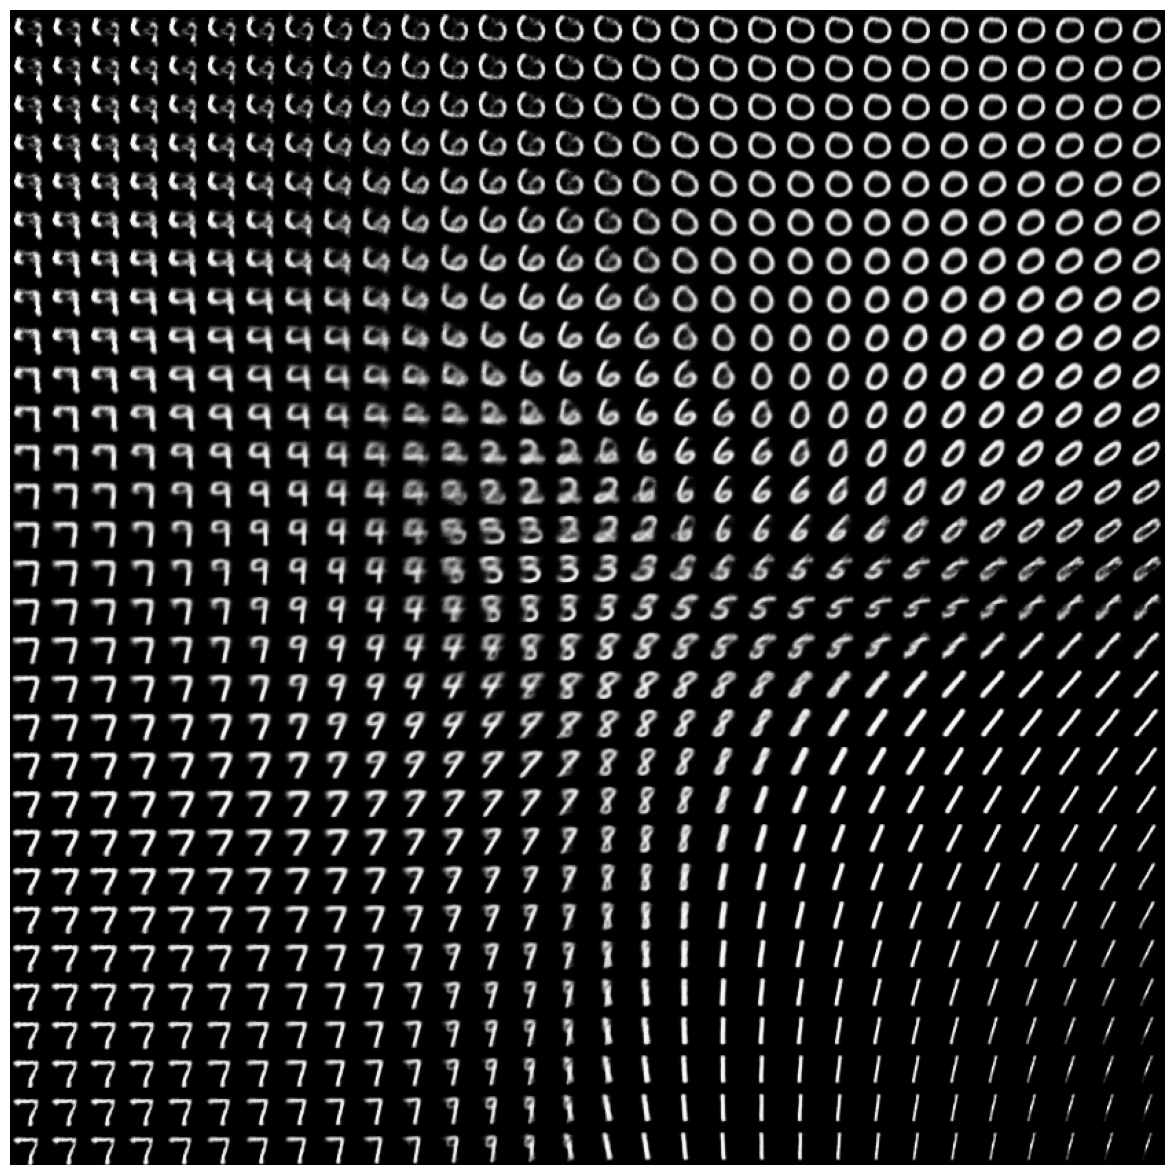

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 3.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.axis('Off')
    plt.show()

# Plot the 2D manifold of digits
plot_latent_space(vae)


1/1 [==============================] - 0s 26ms/step


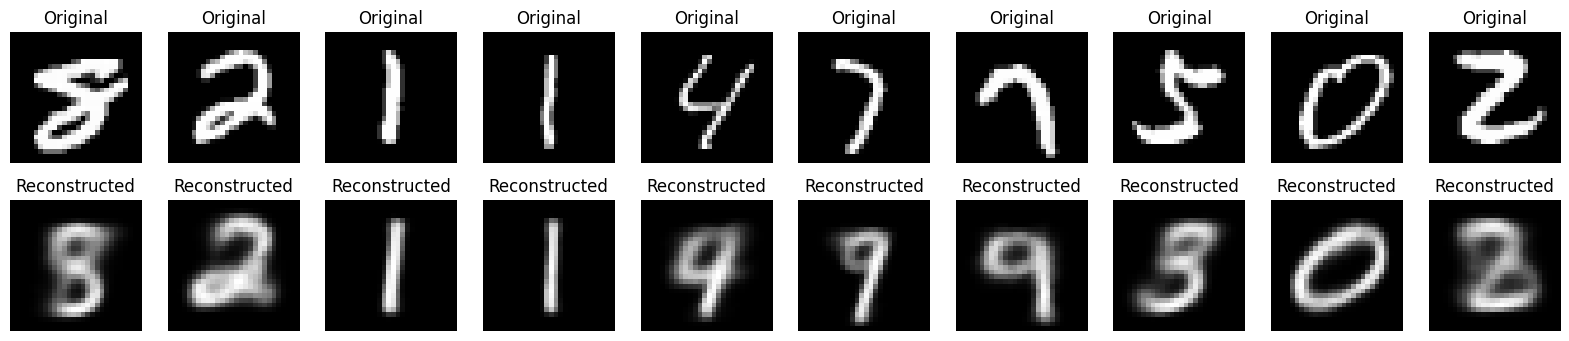

In [ ]:
# Select random images from the test set
num_images = 10
random_idx = np.random.choice(len(x_test), num_images)
test_images = x_test[random_idx]

# Reconstruct the images
z_mean, z_log_var, z = vae.encoder.predict(test_images)
reconstructed_images = vae.decoder.predict(z)

# Plot the original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Original images
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()
